In [1]:
import pandas as pd
import numpy as np
import keras
from keras.utils.data_utils import get_file
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from os.path import join
import multiprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
DATA_HOME1 = '../webface-aligned-with-32-margin-resized/'
DATA_HOME2 = '../faceonly-aligned-with-32-margin-resized/'

In [3]:
dataset1 = pd.read_csv('webface.aligned.train.csv', nrows=None)
dataset1['path'] = dataset1['path'].map(lambda x: join(DATA_HOME1, x))
dataset1['person'] = dataset1['person'].map(str)
dataset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65331 entries, 0 to 65330
Data columns (total 3 columns):
person    65331 non-null object
count     65331 non-null int64
path      65331 non-null object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [4]:
dataset2 = pd.read_csv('facescrub-faceonly.aligned.train.csv', nrows=None)
dataset2['path'] = dataset2['path'].map(lambda x: join(DATA_HOME2, x))
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51959 entries, 0 to 51958
Data columns (total 3 columns):
person    51959 non-null object
count     51959 non-null int64
path      51959 non-null object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
dataset = pd.concat([dataset1, dataset2], axis=0).reset_index()

In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117290 entries, 0 to 117289
Data columns (total 4 columns):
index     117290 non-null int64
person    117290 non-null object
count     117290 non-null int64
path      117290 non-null object
dtypes: int64(2), object(2)
memory usage: 3.6+ MB


In [7]:
encoder = LabelEncoder()
encoder.fit(dataset['person'])
dataset['person_id'] = encoder.transform(dataset['person'])

In [8]:
np.mean(dataset.groupby('person_id')['person'].count())

47.180209171359614

In [9]:
# if the count > 50, will random pick 50 + (count-50)*0.25 imgs for the person
import random
random.seed(42)

def crit(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < 50: return True
    ratio = (50+(count-50)*0.75) / count
    return random.random() < ratio

def crit2(idx):
    row = dataset.ix[idx]
    count = row['count']
    if count < 6: return True
    return False
    
# dataset = dataset.select(crit)
dataset = pd.concat([dataset, dataset.select(crit2)], axis=0).reset_index()

In [10]:
dataset.head()

,level_0,index,person,count,path,person_id
0,0,0,3331486,13,../webface-aligned-with-32-margin-resized/3331...,1134
1,1,1,3331486,13,../webface-aligned-with-32-margin-resized/3331...,1134
2,2,2,3331486,13,../webface-aligned-with-32-margin-resized/3331...,1134
3,3,3,3331486,13,../webface-aligned-with-32-margin-resized/3331...,1134
4,4,4,3331486,13,../webface-aligned-with-32-margin-resized/3331...,1134


In [11]:
np.mean(dataset.groupby('person_id')['person'].count())

47.19991954947707

In [12]:
y = dataset['person_id'].as_matrix()

In [13]:
y = np.concatenate([y,y])
y.shape

(234678,)

In [14]:
img_paths = [r.path for r in dataset.itertuples()]
print(len(img_paths))

117339


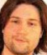

In [15]:
from PIL import Image

load_img(img_paths[0]).transpose(Image.FLIP_LEFT_RIGHT)

In [16]:
def path2ImgVec(path):
    x = img_to_array(load_img(path))
    return x.reshape((1,) + x.shape)

def path2ImgVecFlipped(path):
    img = load_img(path)
    img = img.transpose(Image.FLIP_LEFT_RIGHT)
    x = img_to_array(img)
    return x.reshape((1,) + x.shape)

In [17]:
pool = multiprocessing.Pool(8)
results1 = pool.map(path2ImgVec, img_paths)
pool.close()
pool.join()

In [18]:
pool = multiprocessing.Pool(8)
results2 = pool.map(path2ImgVecFlipped, img_paths)
pool.close()
pool.join()

In [19]:
X = np.vstack(results1+results2)

In [20]:
X.shape

(234678, 55, 47, 3)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)

In [22]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, Input, concatenate
from keras.utils import np_utils
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import accuracy_score
from keras import metrics
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.engine import Model
from keras import optimizers

nb_class = len(np.unique(y))
print('nb_class', nb_class)
hidden_dim = 160
best_weights_filepath = '../models/webface-facescrub-faceonly.best_weights.hdf5'

def build_model():
    image_input = Input(shape=X.shape[1:])
    
    conv1 = Conv2D(20, (4, 4), name='conv1')(image_input)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2), name='pool1')(conv1)
#     pool1 = Dropout(rate=0.2)(pool1)
    
    conv2 = Conv2D(40, (3, 3), name='conv2')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2), name='pool2')(conv2)
#     pool2 = Dropout(rate=0.2)(pool2)

    conv3 = Conv2D(60, (3, 3), name='conv3')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2), name='pool3')(conv3)

    flat1 = Flatten(name='flat1')(pool3)
    
    conv4 = Conv2D(80, (2, 2), name='conv4')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    flat2 = Flatten(name='flat2')(conv4)
    
    merged = concatenate([flat1, flat2])
    
    out = Dense(hidden_dim, name='hidden1')(merged)
    out = BatchNormalization()(out)
    out = Activation('relu',name='deepid')(out)
    out = Dense(nb_class, activation='softmax', name='softmax_class')(out)
    
    model = Model(inputs=image_input, outputs=out)

#     optimizer = optimizers.Adam(lr=1e-2, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=(1e-4))

    model.compile(
        optimizer='adam', #rmsprop
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
    )
    
    print(model.summary())
    return model

nb_class 2486


In [23]:
model = build_model()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 55, 47, 3)     0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 52, 44, 20)    980                                          
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 52, 44, 20)    80                                           
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 52, 44, 20)    0                                            
___________________________________________________________________________________________

In [24]:
saveBestModel = keras.callbacks.ModelCheckpoint(
    best_weights_filepath, 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    mode='auto'
)
earlyStopping=keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    mode='auto'
)

model.fit(
    X_train, 
    y_train, 
    batch_size=512, 
    epochs=10,
    verbose=2, 
    validation_split=0.1, 
    shuffle=True,
    callbacks=[saveBestModel, earlyStopping],
)

Train on 190089 samples, validate on 21121 samples
Epoch 1/12
32s - loss: 5.8292 - acc: 0.1170 - val_loss: 4.9865 - val_acc: 0.1439
Epoch 2/12
31s - loss: 3.3912 - acc: 0.4043 - val_loss: 3.0924 - val_acc: 0.4257
Epoch 3/12
31s - loss: 2.2266 - acc: 0.5786 - val_loss: 2.6905 - val_acc: 0.4839
Epoch 4/12
31s - loss: 1.6615 - acc: 0.6725 - val_loss: 2.2302 - val_acc: 0.5715
Epoch 5/12
31s - loss: 1.3154 - acc: 0.7344 - val_loss: 2.5817 - val_acc: 0.5062
Epoch 6/12
31s - loss: 1.0694 - acc: 0.7789 - val_loss: 2.1330 - val_acc: 0.5825
Epoch 7/12
32s - loss: 0.8746 - acc: 0.8162 - val_loss: 1.9645 - val_acc: 0.6139
Epoch 8/12
32s - loss: 0.7203 - acc: 0.8461 - val_loss: 1.9435 - val_acc: 0.6210
Epoch 9/12
32s - loss: 0.5945 - acc: 0.8715 - val_loss: 1.9692 - val_acc: 0.6179
Epoch 10/12
32s - loss: 0.4915 - acc: 0.8928 - val_loss: 2.0475 - val_acc: 0.6104
Epoch 11/12
32s - loss: 0.4058 - acc: 0.9113 - val_loss: 2.0224 - val_acc: 0.6190
Epoch 12/12
33s - loss: 0.3310 - acc: 0.9281 - val_loss:

In [25]:
model.load_weights(best_weights_filepath)

In [26]:
model.save('../models/webface-facescrub-faceonly-simple-cnn.aligned.flipped.model.h5')

In [27]:
model.evaluate(X_test, y_test, batch_size=512, verbose=2)

[1.9424724528467268, 0.62182546338536004]

In [28]:
import gc
gc.collect()

0